# HW1

In [126]:
import numpy as np
import pandas as pd
import os, glob, tqdm, time
from tqdm import tqdm, trange
import multiprocessing
from multiprocessing import Pool
from sklearn import preprocessing
import scipy.stats as stats
import csv

import networkx as nx
from torch_geometric.data import Data, InMemoryDataset, DataLoader
import torch
import torch.nn as nn
from torch.nn import Linear, Parameter, Sequential
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree, add_self_loops, convert
import torch.nn.functional as F
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch.utils.data import Dataset, DataLoader, TensorDataset


import matplotlib.pyplot as plt

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


## Read Data

In [3]:
os.chdir('/home/rita/111/111-2MLG/HW1')
os.getcwd()

'/home/rita/111/111-2MLG/HW1'

In [5]:
def set_init(graph) :
    row, col = graph.edge_index
    row = row.unsqueeze(0)
    col = col.unsqueeze(0)
    t = torch.hstack([row, col])
    t = t.squeeze()

    deg = degree(t).float().unsqueeze(1)
    print
    extend = torch.ones(graph.num_nodes, 2)
    init = torch.hstack([deg, extend])
    graph.x = init
    
    return graph

In [4]:
youtube_edges = np.array(pd.read_table('./hw1_data/youtube/com-youtube.txt', sep = ' '))
youtube_scores = np.array(pd.read_table('./hw1_data/youtube/com-youtube_score.txt', header = None))
print(type(youtube_edges))
print(type(youtube_scores))
print(youtube_edges.shape)
print(youtube_scores.shape)
print(youtube_edges[:2])
print(youtube_scores[:2])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(2987623, 2)
(1134890, 2)
[[0 2]
 [0 3]]
[['0:' 29320492.911274]
 ['1:' 445191851.627834]]


In [6]:
# 生成圖
youtube = Data(edge_index = torch.from_numpy(youtube_edges.T), num_nodes = youtube_edges.max() + 1)
# print(youtube.x.shape)
youtube = set_init(youtube)
print(type(youtube))
print(len(youtube))
print(youtube.x.shape)
print(youtube.x[0])
print(f'Number of nodes: {youtube.num_nodes}')
print(f'Number of edges: {youtube.num_edges}')

<class 'torch_geometric.data.data.Data'>
3
torch.Size([1134890, 3])
tensor([28.,  1.,  1.])
Number of nodes: 1134890
Number of edges: 2987623


In [7]:
path = '/home/rita/111/111-2MLG/HW1/hw1_data/Synthetic/5000'
os.chdir(path)
files = glob.glob('*')
file_name = [x[:-4] for x in files]

total_data = {}
for i in range(len(files)) :
    total_data[file_name[i]] = np.array(pd.read_table(files[i], header = None))

print(len(total_data))
print(type(total_data))
print(type(total_data[file_name[0]]))
print(type(total_data[file_name[-1]]))
print(total_data[file_name[0]][:2])
print(total_data[file_name[-1]][:2])

60
<class 'dict'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[0.         0.04482959]
 [1.         0.11496664]]
[[0 4]
 [0 5]]


In [8]:
# 生成圖
total_graph = {}
for i in range(len(files)//2):
    edge = total_data[str(i)]
    temp = Data(edge_index =  torch.from_numpy(edge.T), num_nodes = edge.max() + 1)
    total_graph[i] = set_init(temp)
print(len(total_graph))
print(len(total_graph[0]))
print(type(total_graph))
print(type(total_graph[0]))
print(type(total_graph[29]))
print(total_graph[0])
print(total_graph[29])
print(total_graph[0].x)

30
3
<class 'dict'>
<class 'torch_geometric.data.data.Data'>
<class 'torch_geometric.data.data.Data'>
Data(edge_index=[2, 19982], num_nodes=5000, x=[5000, 3])
Data(edge_index=[2, 19983], num_nodes=5000, x=[5000, 3])
tensor([[239.,   1.,   1.],
        [178.,   1.,   1.],
        [149.,   1.,   1.],
        ...,
        [  4.,   1.,   1.],
        [  4.,   1.,   1.],
        [  4.,   1.,   1.]])


In [50]:
path = '/home/rita/111/111-2MLG/HW1/hw1_data/Synthetic/5000'
os.chdir(path)
files = glob.glob('*score.*')
file_name = [x[:-10] for x in files]

total_score = {}
for i in range(len(file_name)) :
    total_score[file_name[i]] = np.array(pd.read_table(files[i], header = None))
print(total_score['0'])

[[0.00000000e+00 9.41745309e-02]
 [1.00000000e+00 5.39707966e-02]
 [2.00000000e+00 4.43436579e-02]
 ...
 [4.99700000e+03 1.95420222e-05]
 [4.99800000e+03 6.05783053e-05]
 [4.99900000e+03 1.09075567e-04]]


In [100]:
os.chdir('/home/rita/111/111-2MLG/HW1')
os.getcwd()

'/home/rita/111/111-2MLG/HW1'

## Model

In [11]:
# GCNconv
# 修改成 Algorithm 裡面的樣子
class GCNConv_self(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).

    def forward(self, x, edge_index):
        row, col = edge_index
        row = row.unsqueeze(0)
        col = col.unsqueeze(0)
        t = torch.hstack([row, col])
        t = t.squeeze()
        
        deg = degree(t, x.size(0), dtype=x.dtype) + 1
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        out = self.propagate(edge_index, x=x, norm=norm)

        return out

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

In [12]:
# DrBC
# ENCODER DECODER
class DrBC(nn.Module) :
    def __init__(self, encoder_layers = 5, emb_dim = 128) :
        super(DrBC, self).__init__()
        # encoder
        self.encoder_layers = encoder_layers
        self.emb_dim = emb_dim
        # self.n_nodes = n_nodes
        self.line2 = nn.Sequential(
            nn.Linear(3, self.emb_dim),  # w0 (5000 * p)
            nn.ReLU()
        )
        self.line5 = GCNConv_self(self.emb_dim, self.emb_dim)
        # w1, u1, w2, u2, w3, u3  (p * p)
        self.line6 = nn.GRUCell(input_size = self.emb_dim, hidden_size = self.emb_dim, bias = False) # (p * p)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.emb_dim, 32),  # w4
            nn.ReLU(), 
            nn.Linear(32, 1),  # w5
            # nn.Sigmoid()
        )
        
    def forward(self, graph) :
        # encoder
        hv_0 = graph.x
        hv = self.line2(hv_0)
        hv = F.normalize(hv) # hv / |hv|2
        
        total_hv = hv.unsqueeze(0).clone().detach()
        # total_hv = torch.tensor(hv.unsqueeze(0))
        for i in range(2, self.encoder_layers + 1) :
            hnv = self.line5(hv, graph.edge_index)
            hv = self.line6(hnv, hv)
            hv = F.normalize(hv)
            total_hv = torch.vstack((total_hv, hv.unsqueeze(0))) # (3, 500, 64)
        
        z_v, _ = torch.max(total_hv, dim = 0)
        
        # decoder
        out = self.decoder(z_v)

        return out
model = DrBC().to(device)
print(model)

DrBC(
  (line2): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
  )
  (line5): GCNConv_self()
  (line6): GRUCell(128, 128, bias=False)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


### Train

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.") #可以根據輸出結果知道是否有可用的GPUa

In [161]:
def training_loop(model, n_epochs, optimizer, loss_fn, scale, batch_size = 16) : # , loss_fn, train_loader
    ls_loss = []
    t = tqdm(range(1, n_epochs + 1), total = n_epochs)
    for epoch in t :   
        start = 0
        for i in range(batch_size) :
            if (len(scale) == 1) : 
                s = scale[0]
            else : 
                s = int(np.random.randint(scale[0], scale[1], 1))
            # Draw network G from distribution D (like the power-law model)
            g = nx.powerlaw_cluster_graph(s, 7, 0.5)
            # [dv, 1, 1]
            degrees = list(dict(g.degree()).values())
            degree_tensor = torch.tensor(degrees).float().unsqueeze(1)
            extend = torch.ones(s, 2)
            init = torch.hstack([degree_tensor, extend])
            edge_index = torch.tensor(list(g.edges())) + start
            
            # Calculate each node’s exact BC value bv, ∀v ∈ V
            # 1-n
            exact_bc = nx.betweenness_centrality(g)
            exact_bc = torch.tensor(list(exact_bc.values()))
            exact_bc = np.log(exact_bc + 1e-8)
            
            # 隨機取排列組合
            input_tensor = torch.tensor(range(start, start + s))
            combinations_tensor = torch.combinations(input_tensor, r = 2)
            num_combinations = combinations_tensor.shape[0]
            indices = torch.randperm(num_combinations)[:5 * s]
            node_pair = combinations_tensor[indices]
            
            if (i == 0) : 
                total_init = init
                total_exact_bc = exact_bc
                total_node_pair = node_pair
                total_edge_index = edge_index
            else : 
                total_init = torch.vstack([total_init, init])
                total_exact_bc = torch.cat([total_exact_bc, exact_bc])
                total_node_pair = torch.vstack([total_node_pair, node_pair])
                total_edge_index = torch.vstack([total_edge_index, edge_index])
                
            start += s
            
        idx1 = total_node_pair[::, 0]
        idx2 = total_node_pair[::, 1]
        pyg_g = Data(edge_index = total_edge_index.T, num_nodes = total_edge_index.max() + 1)
        pyg_g.x = total_init
        pred_bc = model(pyg_g.to(device = device))
        
        pred_a = pred_bc[idx1]
        pred_b = pred_bc[idx2]
        yij = pred_a - pred_b
        exact_a = total_exact_bc[idx1]
        exact_b = total_exact_bc[idx2]
        bij = (exact_a - exact_b).to(device)
        
        yij = yij.squeeze() # (n, )
        
        # bij = (bij-torch.mean(bij)) / torch.std(bij)
        # yij = (yij-torch.mean(yij)) / torch.std(yij)
        
        loss = loss_fn(yij, torch.sigmoid(bij))
        ls_loss.append(loss.item())
        # Update Θ = (ΘEN C, ΘDEC ) with Adam by minimizing Eq. (15)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        t.set_description(f'Epoch[{epoch} / {n_epochs}]')
        t.set_postfix(loss = loss.item())
        
    if (len(scale) == 1) : 
        filename = './model/DrBC_{}.pt'.format(scale)
    else : 
        filename = './model/DrBC_{}_{}.pt'.format(scale[0], scale[1])
    torch.save(model.state_dict(), filename)
    print(filename[8:], 'Finish Training ! ')
    return ls_loss

In [162]:
# train and save model
# table 6, table 7
learning_rate = 1e-4
embedding_dimension = 128
mini_batch_size = 16
average_node_sampling_times = 5
maximum_episodes = 10 ** 4
layer_iterations = 5
model = DrBC(encoder_layers = layer_iterations, emb_dim = embedding_dimension).to(device = device)
loss_fn = nn.BCEWithLogitsLoss(reduction = 'sum')
loss_fn = nn.BCEWithLogitsLoss() # 0.693
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)
n_epochs = 100

train_scale = [[100, 200], [300, 400], [500, 600], [700, 800], [900, 1000]]
test_scale = [5000, 10000, 20000, 50000, 100000]

loss = {}
for i in train_scale[:1] :
    ls_loss = training_loop(
        model = model, 
        n_epochs = n_epochs, 
        optimizer = optimizer, 
        loss_fn = loss_fn, 
        scale = i, 
        batch_size = mini_batch_size

    )
    loss[str(i)] = ls_loss
# np.save('loss_small.npy', loss)

Epoch[100 / 100]: 100%|██████████| 100/100 [02:18<00:00,  1.38s/it, loss=0.658]

DrBC_100_200.pt Finish Training ! 


In [149]:
l = np.load('loss_small.npy')
l

FileNotFoundError: [Errno 2] No such file or directory: 'loss_small.npy'

In [122]:
# 好像是跑不了 =)
scale = [[5000], [10000], [20000], [50000], [100000]]
for i in scale[:1] :
    ls_loss = training_loop(
        model = model, 
        n_epochs = n_epochs, 
        optimizer = optimizer, 
        loss_fn = loss_fn, 
        scale = i, 
        batch_size = mini_batch_size

    )
    loss[str(i)] = ls_loss

  0%|          | 0/10 [01:12<?, ?it/s]


KeyboardInterrupt: 

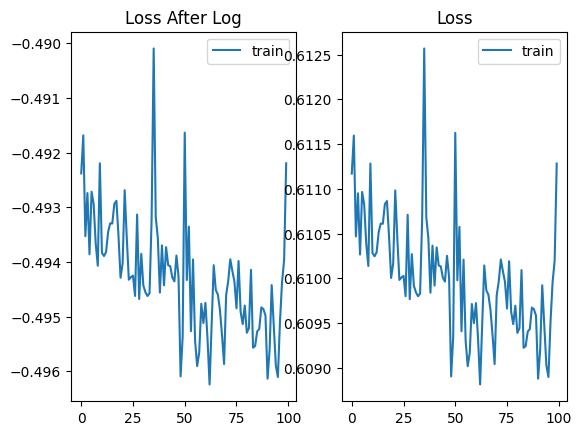

In [155]:
plt.subplot(1, 2, 1)
plt.title('Loss After Log')
temp = np.array(ls_loss)
temp = np.log(temp)
plt.plot(range(n_epochs), temp, label="train")
plt.legend()
plt.savefig('loss.png')
# plt.show()
plt.subplot(1, 2, 2)
plt.title('Loss')
temp = np.array(ls_loss)
temp = np.log(temp)
plt.plot(range(n_epochs), ls_loss, label="train")
plt.legend()
plt.savefig('loss.png')
plt.show()

### Test

In [82]:
def test_data(model, graph, exact_bc, top_n, device = torch.device('cpu')) :
    s = time.time()
    model = model.to(device)
    pred_bc = model(graph.to(device))
    exact_bc = np.argsort(exact_bc[::, 1])
    top = []
    for n in top_n : 
        s = time.time()
        num = int(np.ceil(graph.num_nodes * n / 100))
        exact = np.argsort(exact_bc)[-num:]
        pred = torch.argsort(pred_bc, dim = 0)[-num:].cpu()
        acc = len(np.intersect1d(exact, pred)) / num
        top.append(acc)
        # print('Top ', n, ' Accuracy : %.4f'%acc )
    t = time.time() - s
    # print('Running Time : ', t)
    tau_dist, _ = stats.kendalltau(pred_bc.cpu().detach().numpy(), exact_bc)
    top.append(tau_dist)
    top.append(t)
    # print('Kendall tau distance : %.4f'%tau_dist)
    # return np.array(top).reshape(1, -1)
    return top

In [ ]:
# test for youtube
# 先不能跑
top = test_data(
    model = model, 
    graph = youtube, 
    exact_bc = youtube_score, 
    top_n = [1, 5, 10], 
    device = torch.device('cpu')
)
top = np.array(top)
print('Top 1 Accuracy : {:.1f}'.format(top[0]))
print('Top 5 Accuracy : {:.1f}'.format(top[1]))
print('Top 10 Accuracy : {:.1f}'.format(top[2]))
print('Kendall tau distance : {:.1f}'.format(top[3]))
print('Running Time : {:.1f}'.format(top[4]))

In [164]:
# test for 30 graph
def test_30(model, graph, score, n = 30):
    t = []
    top_n = [1, 5, 10]
    for i in  range(n): 
        top = test_data(
            model = model, 
            graph = graph[i], 
            exact_bc = score[str(i)], 
            top_n = top_n, 
            device = torch.device('cpu')
        )
        t.append(top)
    t = np.array(t)
    t_mean = np.mean(t, axis = 0) * 100
    t_std = np.std(t, axis = 0) * 100
    print('Top',  top_n[0],  'Accuracy : {:.1f}±{:.1f}'.format(t_mean[0], t_std[0]))
    print('Top',  top_n[1],  'Accuracy : {:.1f}±{:.1f}'.format(t_mean[1], t_std[1]))
    print('Top',  top_n[2],  'Accuracy : {:.1f}±{:.1f}'.format(t_mean[2], t_std[2]))
    print('Kendall tau distance : {:.1f}±{:.1f}'.format(t_mean[3], t_std[3]))
    print('time : ', t_mean[4] * n)

test_30(
    model = model, 
    graph = total_graph, 
    score = total_score, 
    n = 30
)

Top 1 Accuracy : 3.2±2.9
Top 5 Accuracy : 14.6±2.1
Top 10 Accuracy : 27.6±1.5
Kendall tau distance : 37.6±0.7
time :  3.07016372680664


In [163]:
# parameters
learning_rate = 1e-4
embedding_dimension = 128
maximum_episodes = 10 ** 4
layer_iterations = 5
loss_fn = nn.BCEWithLogitsLoss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)
model = DrBC(encoder_layers = layer_iterations, emb_dim = embedding_dimension)
train_scale = [[100, 200], [300, 400], [500, 600], [700, 800], [900, 1000]]
s = train_scale[0]
model.load_state_dict(torch.load('./model/DrBC_{}_{}.pt'.format(s[0], s[1])))

<All keys matched successfully>

In [ ]:
# different scale
# not yet
def diff_scale(train_scale, test_scale) :
    for i in train_scale :
        for j in test_scale :
            # generate 30 graoh
            
            
            # test
            
            